In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=693be5034ad530b754246b0262724f75c389c0227003530739300c20d7a508cc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Initialize Spark Session
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()

# 1. Load the dataset from csv file
df = spark.read.csv("/content/BostonHousing.csv", sep=",", header = True, inferSchema=True)

## Task 1: Data Overview

In [3]:
# First 5 elements of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [4]:
# Number of observations in the dataset
observation_count = df.count()
print(f"Number of observations: {observation_count}")

Number of observations: 506


## Task 2: Descriptive Statistics

In [8]:
# Basic statistics for "medv" column
from pyspark.sql.functions import mean, stddev, min, max

medv_stats = df.select(
    mean('medv').alias('mean_medv'),
    stddev('medv').alias('stddev_medv'),
    min('medv').alias('min_medv'),
    max('medv').alias('max_medv')
).first()

print(f"Mean MEDV: {medv_stats['mean_medv']}")
print(f"Standard Deviation of MEDV: {medv_stats['stddev_medv']}")
print(f"Minimum MEDV: {medv_stats['min_medv']}")
print(f"Maximum MEDV: {medv_stats['max_medv']}")

Mean MEDV: 22.532806324110698
Standard Deviation of MEDV: 9.197104087379815
Minimum MEDV: 5.0
Maximum MEDV: 50.0


In [9]:
# Mean of "rm"
mean_rm = df.select(mean('rm').alias('mean_rm')).first()['mean_rm']
print(f"Mean RM: {mean_rm}")

Mean RM: 6.284634387351787


## Task 3: Data Exploration

In [10]:
# Property with the highest crime rate
highest_crim_property = df.orderBy(col('crim').desc()).first()
print(f"Property with the highest crime rate: {highest_crim_property}")

Property with the highest crime rate: Row(crim=88.9762, zn=0.0, indus=18.1, chas=0, nox=0.671, rm=6.968, age=91.9, dis=1.4165, rad=24, tax=666, ptratio=20.2, b=396.9, lstat=17.21, medv=10.4)


In [11]:
# Property with the lowest median home value
lowest_medv_property = df.orderBy(col('medv').asc()).first()
print(f"Property with the lowest median home value: {lowest_medv_property}")

Property with the lowest median home value: Row(crim=38.3518, zn=0.0, indus=18.1, chas=0, nox=0.693, rm=5.453, age=100.0, dis=1.4896, rad=24, tax=666, ptratio=20.2, b=396.9, lstat=30.59, medv=5.0)


## Task 4: Data Distribution Analysis

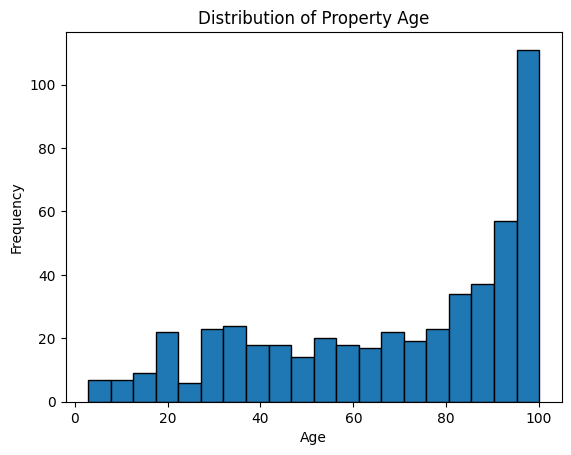

In [12]:
import matplotlib.pyplot as plt

# Converting Spark DataFrame to Pandas for visualization
df_pandas = df.toPandas()

# Plot histogram for "age"
plt.hist(df_pandas['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Property Age')
plt.show()

In [13]:
# Percentage of properties with "chas" value of 1
total_properties = df.count()
chas_count = df.filter(col('chas') == 1).count()
chas_percentage = (chas_count / total_properties) * 100
print(f"Percentage of properties with CHAS = 1: {chas_percentage}%")

Percentage of properties with CHAS = 1: 6.91699604743083%


## Task 5: Correlation Analysis

In [14]:
# Correlation between "rm" and "medv"
corr_rm_medv = df.stat.corr('rm', 'medv')
print(f"Correlation between RM and MEDV: {corr_rm_medv}")

Correlation between RM and MEDV: 0.6953599470715401


The correlation coefficient between RM and MEDV is positive (0.7), indicating a positive relationship between the two variables.
This means that as the average number of rooms in a property increases, the median home value also tends to increase and the strength of this relationship is moderate.

In [15]:
# Correlation between "ptratio" and "nox"
corr_ptratio_nox = df.stat.corr('ptratio', 'nox')
print(f"Correlation between PTRATIO and NOX: {corr_ptratio_nox}")

Correlation between PTRATIO and NOX: 0.18893267711276893


The correlation between PTRATIO and NOX is positve and weak (closer to 0). This suggests that there isn't any meaningful relationship between pupil-teacher ratio and nitrogen oxide concentration.

## Task 6: Advanced Querying

In [16]:
# Register DataFrame as a SQL temporary view
df.createOrReplaceTempView("boston_housing")

# Top 5 neighborhoods with highest median home values
top_5_neighborhoods = spark.sql("""
    SELECT zn, AVG(medv) AS avg_medv
    FROM boston_housing
    GROUP BY zn
    ORDER BY avg_medv DESC
    LIMIT 5
""")
top_5_neighborhoods.show()

+----+-----------------+
|  zn|         avg_medv|
+----+-----------------+
|95.0|           41.575|
|90.0|            38.34|
|20.0|35.46666666666666|
|45.0|33.43333333333333|
|82.5|             33.2|
+----+-----------------+



In [17]:
# Average property age for neighborhoods with CHAS value of 1 and 0
avg_age_chas = spark.sql("""
    SELECT chas, AVG(age) AS avg_age
    FROM boston_housing
    GROUP BY chas
""")
avg_age_chas.show()

+----+-----------------+
|chas|          avg_age|
+----+-----------------+
|   1|77.50000000000001|
|   0|67.91167728237794|
+----+-----------------+



## Task 7: Visualization

In [18]:
# Create a Hive view in Spark that includes the "age" and "medv" columns.
df.select('age', 'medv').createOrReplaceTempView("property_age_view")

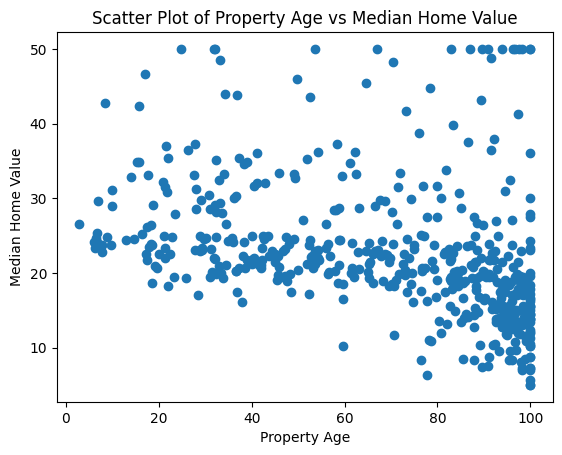

In [19]:
# Plot scatter plot for property age vs median home value
plt.scatter(df_pandas['age'], df_pandas['medv'])
plt.xlabel('Property Age')
plt.ylabel('Median Home Value')
plt.title('Scatter Plot of Property Age vs Median Home Value')
plt.show()

## Task 8: Outliers Detection

In [20]:
# Properties with "crim" value greater than 10
outliers = df.filter(col('crim') > 10)
outliers.show()

+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|13.5222|0.0| 18.1|   0|0.631|3.863|100.0|1.5106| 24|666|   20.2|131.42|13.33|23.1|
|11.1081|0.0| 18.1|   0|0.668|4.906|100.0|1.1742| 24|666|   20.2| 396.9|34.77|13.8|
|18.4982|0.0| 18.1|   0|0.668|4.138|100.0| 1.137| 24|666|   20.2| 396.9|37.97|13.8|
|19.6091|0.0| 18.1|   0|0.671|7.313| 97.9|1.3163| 24|666|   20.2| 396.9|13.44|15.0|
| 15.288|0.0| 18.1|   0|0.671|6.649| 93.3|1.3449| 24|666|   20.2|363.02|23.24|13.9|
|23.6482|0.0| 18.1|   0|0.671| 6.38| 96.2|1.3861| 24|666|   20.2| 396.9|23.69|13.1|
|17.8667|0.0| 18.1|   0|0.671|6.223|100.0|1.3861| 24|666|   20.2|393.74|21.78|10.2|
|88.9762|0.0| 18.1|   0|0.671|6.968| 91.9|1.4165| 24|666|   20.2| 396.9|17.21|10.4|
|15.8744|0.0| 18.1|   0|0.671|6.545| 99.1|1.5192| 24|666|   20.2| 396.9|21.0

**Significance of Detecting Outliers:**

Outliers can significantly affect the results of data analysis. They can skew averages, inflate standard deviations, and affect the performance of machine learning models. Identifying outliers helps in understanding anomalies in the data, ensuring data quality, and making more accurate predictions.

## Task 9: Hypothesis Testing

**Hypothesis:**



*   Null Hypothesis (H0): There is no significant
impact of the number of rooms (rm) on the median home value (medv).

*   Alternative Hypothesis (H1): The number of rooms (rm) has a significant impact on the median home value (medv).

In [21]:
from scipy.stats import ttest_ind

# Split data into two groups based on the average number of rooms
rm_high = df_pandas[df_pandas['rm'] > df_pandas['rm'].mean()]['medv']
rm_low = df_pandas[df_pandas['rm'] <= df_pandas['rm'].mean()]['medv']

# Perform t-test
t_stat, p_value = ttest_ind(rm_high, rm_low)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant impact of the number of rooms on median home value.")
else:
    print("Fail to reject the null hypothesis. There is no significant impact of the number of rooms on median home value.")

T-statistic: 12.330892109480521, P-value: 1.0219268491471897e-30
Reject the null hypothesis. There is a significant impact of the number of rooms on median home value.
